In [1]:
import numpy
print(numpy.__version__)


1.23.5


In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import os


In [3]:
os.chdir("../")
%pwd

'/home/malik-harris/tekhqs/stocks/OHLCV-stock-pred'

In [4]:
df = pd.read_csv("data/raw/ohlcv/AAPL.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df = df.sort_index()
df.head()


,Open,High,Low,Close,Volume
Date,,,,,
2015-06-01,29.178397,29.427001,29.126886,29.236628,128451200
2015-06-02,29.084331,29.263506,28.963391,29.106730,134670400
2015-06-03,29.263509,29.326219,29.093292,29.142565,123934000
2015-06-04,29.021628,29.245595,28.871570,28.972355,153800400
2015-06-05,29.003701,29.046255,28.748379,28.813328,142507200


In [5]:
def rolling_slope(series, window):
    x = np.arange(window)
    slopes = [np.nan] * window
    for i in range(window, len(series)):
        y = series[i - window:i]
        A = np.vstack([x, np.ones(len(x))]).T
        m, _ = np.linalg.lstsq(A, y, rcond=None)[0]
        slopes.append(m)
    return pd.Series(slopes, index=series.index)


In [6]:
# ----- Price Momentum & Trend -----
df["return_1d"] = df["Close"].pct_change(1)
df["return_5d"] = df["Close"].pct_change(5)
df["return_10d"] = df["Close"].pct_change(10)
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

df["sma_10"] = ta.sma(df["Close"], length=10)
df["sma_20"] = ta.sma(df["Close"], length=20)
df["sma_50"] = ta.sma(df["Close"], length=50)
df["sma_200"] = ta.sma(df["Close"], length=200)

df["ema_12"] = ta.ema(df["Close"], length=12)
df["ema_26"] = ta.ema(df["Close"], length=26)
df[["macd", "macd_signal", "macd_hist"]] = ta.macd(df["Close"])
df["roc_10"] = ta.roc(df["Close"], length=10)
df["slope_10"] = rolling_slope(df["Close"], 10)

# ----- Volatility -----
df["rolling_std_10"] = df["Close"].rolling(10).std()
df["atr_14"] = ta.atr(df["High"], df["Low"], df["Close"], length=14)
# Add RSI with 14-period (default)
df['RSI'] = ta.rsi(df['Close'], length=14)
bb = ta.bbands(df["Close"], length=20)
df["bollinger_high"] = bb["BBU_20_2.0"]
df["bollinger_low"] = bb["BBL_20_2.0"]
df["bb_width"] = df["bollinger_high"] - df["bollinger_low"]
df["zscore_20"] = (df["Close"] - df["Close"].rolling(20).mean()) / (df["Close"].rolling(20).std() + 1e-6)

# ----- Volume -----
df["volume_change_1d"] = df["Volume"].pct_change(1)
df["volume_avg_20"] = df["Volume"].rolling(20).mean()
df["volume_spike"] = df["Volume"] / (df["volume_avg_20"] + 1e-6)
df["obv"] = ta.obv(df["Close"], df["Volume"])

# ----- Candlestick -----
df["candle_body"] = df["Close"] - df["Open"]
df["upper_wick"] = df["High"] - df[["Close", "Open"]].max(axis=1)
df["lower_wick"] = df[["Close", "Open"]].min(axis=1) - df["Low"]
df["candle_range"] = df["High"] - df["Low"]
df["body_ratio"] = df["candle_body"] / (df["candle_range"] + 1e-6)
df["doji_flag"] = (df["candle_body"].abs() / (df["candle_range"] + 1e-6)) < 0.1

# ----- Lag Features -----
for i in range(1, 6):
    df[f"close_lag{i}"] = df["Close"].shift(i)
    df[f"return_lag{i}"] = df["return_1d"].shift(i)

In [7]:
df.dropna(inplace=True)
df.head(10)


,Open,High,Low,Close,Volume,return_1d,return_5d,return_10d,log_return,sma_10,...,close_lag1,return_lag1,close_lag2,return_lag2,close_lag3,return_lag3,close_lag4,return_lag4,close_lag5,return_lag5
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-15,23.616559,23.893706,23.591570,23.757404,160270800,0.020094,0.035138,0.040287,0.019895,23.166990,...,23.289433,0.002542,23.230371,0.010774,22.982759,0.000495,22.971394,0.000891,22.950945,-0.008246
2016-03-16,23.764219,24.150407,23.759674,24.073170,153214000,0.013291,0.047963,0.051811,0.013204,23.285572,...,23.757404,0.020094,23.289433,0.002542,23.230371,0.010774,22.982759,0.000495,22.971394,0.000891
2016-03-17,23.970937,24.186749,23.843723,24.034546,137682800,-0.001604,0.045764,0.042364,-0.001606,23.383255,...,24.073170,0.013291,23.757404,0.020094,23.289433,0.002542,23.230371,0.010774,22.982759,0.000495
2016-03-18,24.157220,24.193568,23.895977,24.061810,176820800,0.001134,0.035791,0.028250,0.001134,23.449361,...,24.034546,-0.001604,24.073170,0.013291,23.757404,0.020094,23.289433,0.002542,23.230371,0.010774
2016-03-21,24.064084,24.454816,23.884620,24.059542,142010800,-0.000094,0.033067,0.039658,-0.000094,23.541137,...,24.061810,0.001134,24.034546,-0.001604,24.073170,0.013291,23.757404,0.020094,23.289433,0.002542
2016-03-22,23.909608,24.373034,23.900521,24.243547,129777600,0.007648,0.020463,0.056320,0.007619,23.670398,...,24.059542,-0.000094,24.061810,0.001134,24.034546,-0.001604,24.073170,0.013291,23.757404,0.020094
2016-03-23,24.189029,24.323058,24.057270,24.109518,102814000,-0.005528,0.001510,0.049545,-0.005544,23.784210,...,24.243547,0.007648,24.059542,-0.000094,24.061810,0.001134,24.034546,-0.001604,24.073170,0.013291
2016-03-24,23.959587,24.136779,23.827828,24.005020,104532000,-0.004334,-0.001228,0.044479,-0.004344,23.886436,...,24.109518,-0.005528,24.243547,0.007648,24.059542,-0.000094,24.061810,0.001134,24.034546,-0.001604
2016-03-28,24.079986,24.123149,23.866446,23.895979,77645600,-0.004542,-0.006892,0.028652,-0.004553,23.952997,...,24.005020,-0.004334,24.109518,-0.005528,24.243547,0.007648,24.059542,-0.000094,24.061810,0.001134


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline


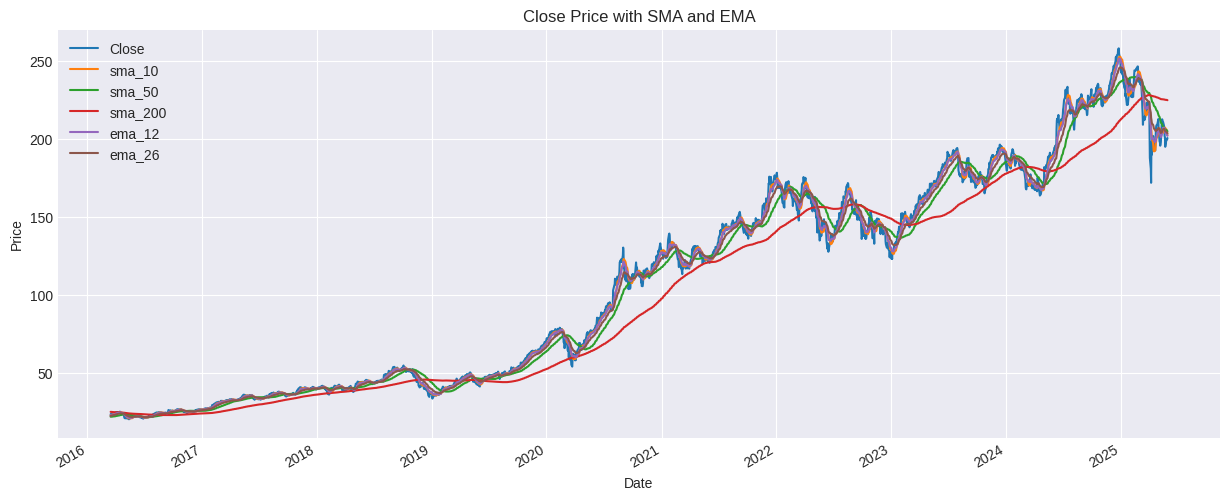

In [11]:
df[['Close', 'sma_10', 'sma_50', 'sma_200', 'ema_12', 'ema_26']].plot(figsize=(15, 6), title='Close Price with SMA and EMA')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid(True)
plt.show()


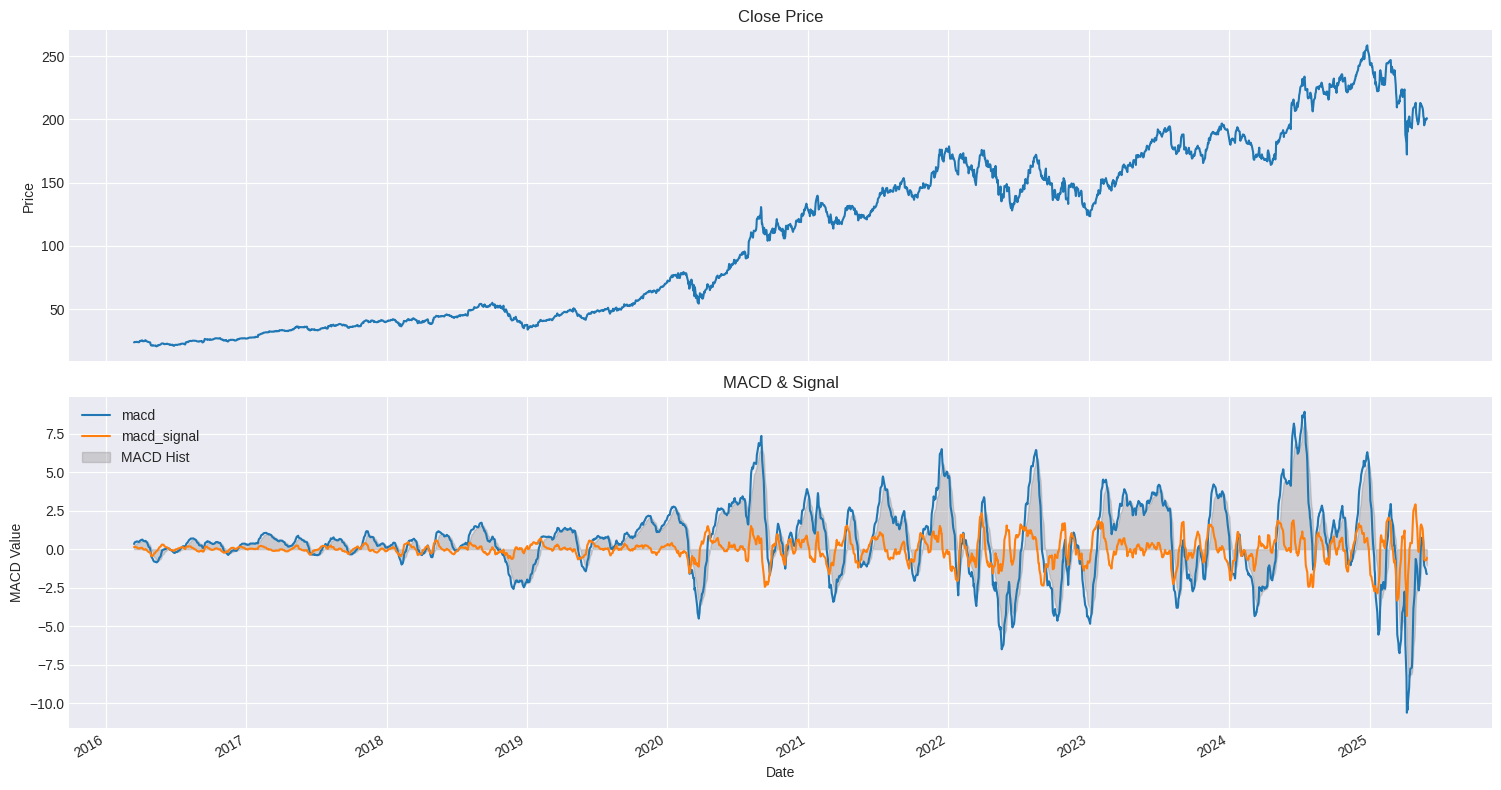

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

df['Close'].plot(ax=ax[0], title='Close Price')
ax[0].set_ylabel('Price')

df[['macd', 'macd_signal']].plot(ax=ax[1], title='MACD & Signal')
ax[1].fill_between(df.index, df['macd_hist'], color='gray', alpha=0.3, label='MACD Hist')
ax[1].legend()
ax[1].set_ylabel('MACD Value')

plt.tight_layout()
plt.show()


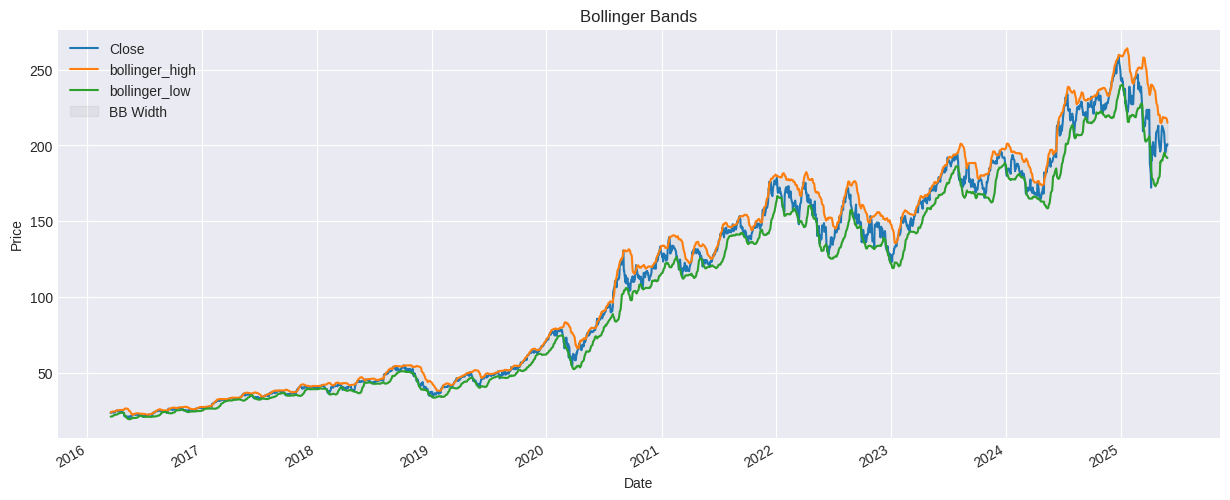

In [13]:
df[['Close', 'bollinger_high', 'bollinger_low']].plot(figsize=(15, 6), title='Bollinger Bands')
plt.fill_between(df.index, df['bollinger_high'], df['bollinger_low'], alpha=0.1, color='gray', label='BB Width')
plt.legend()
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()


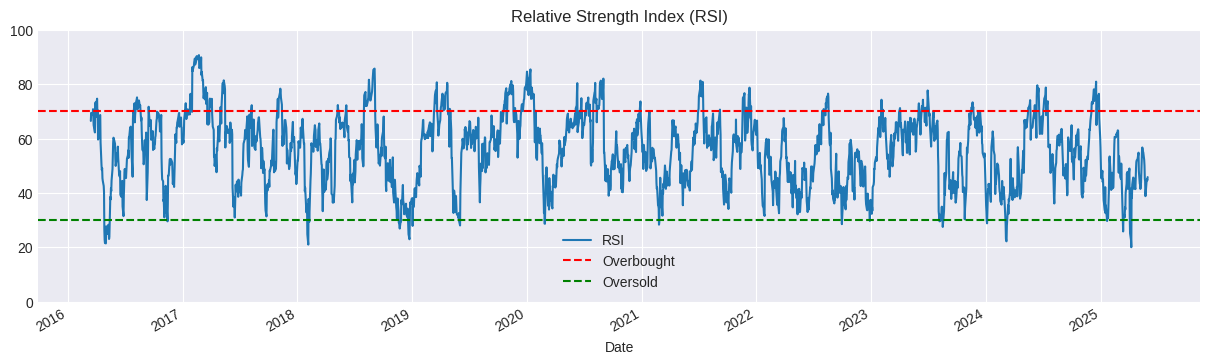

In [14]:
df['RSI'].plot(figsize=(15, 4), title='Relative Strength Index (RSI)')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.ylim(0, 100)
plt.legend()
plt.show()


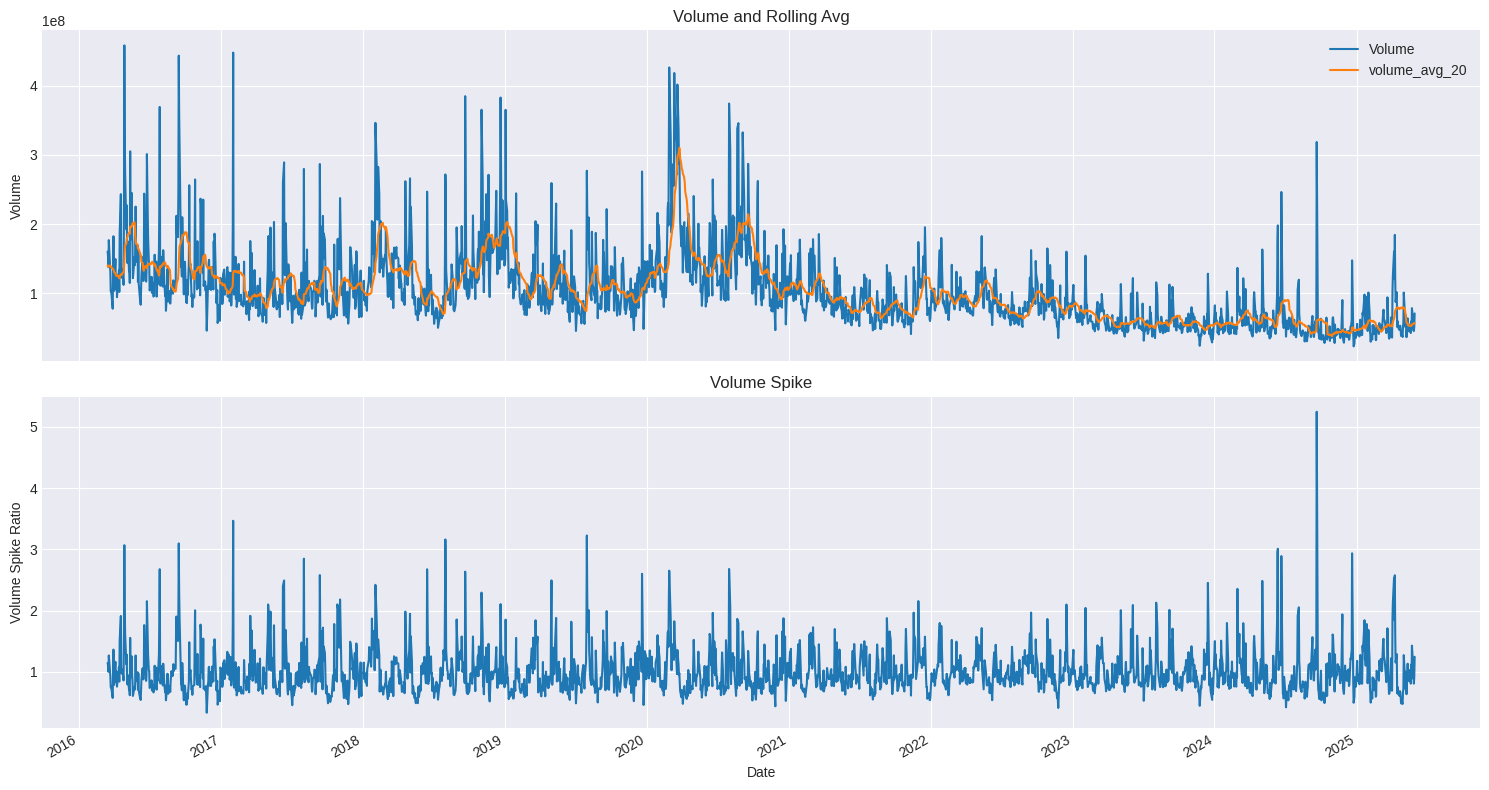

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

df[['Volume', 'volume_avg_20']].plot(ax=ax[0], title='Volume and Rolling Avg')
ax[0].set_ylabel('Volume')

df['volume_spike'].plot(ax=ax[1], title='Volume Spike')
ax[1].set_ylabel('Volume Spike Ratio')

plt.tight_layout()
plt.show()


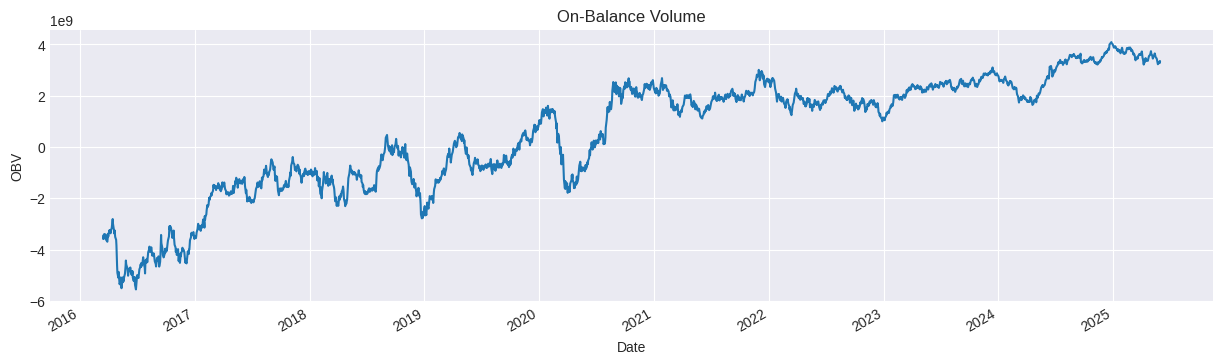

In [16]:
df['obv'].plot(figsize=(15, 4), title='On-Balance Volume')
plt.ylabel('OBV')
plt.show()


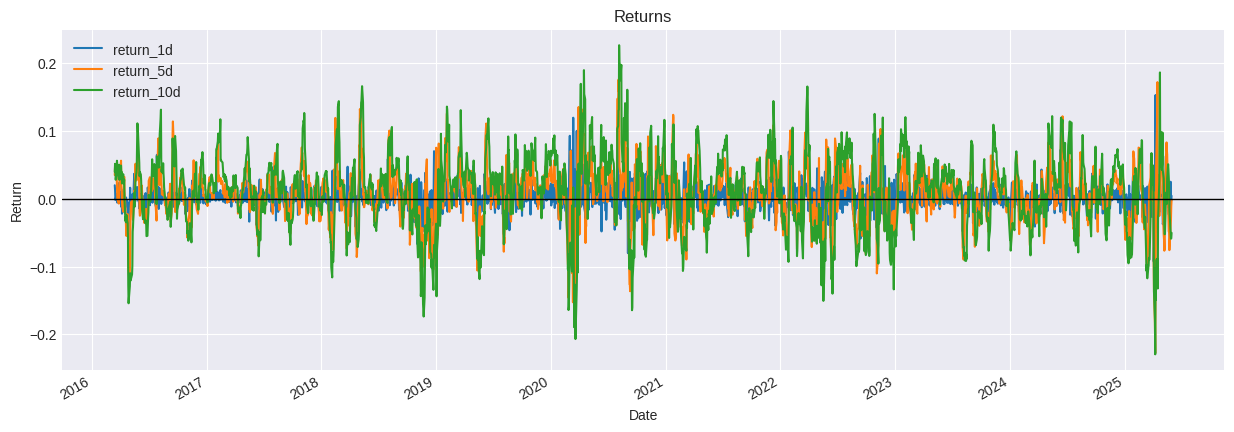

In [17]:
df[['return_1d', 'return_5d', 'return_10d']].plot(figsize=(15, 5), title='Returns')
plt.axhline(0, color='black', linewidth=1)
plt.ylabel('Return')
plt.show()


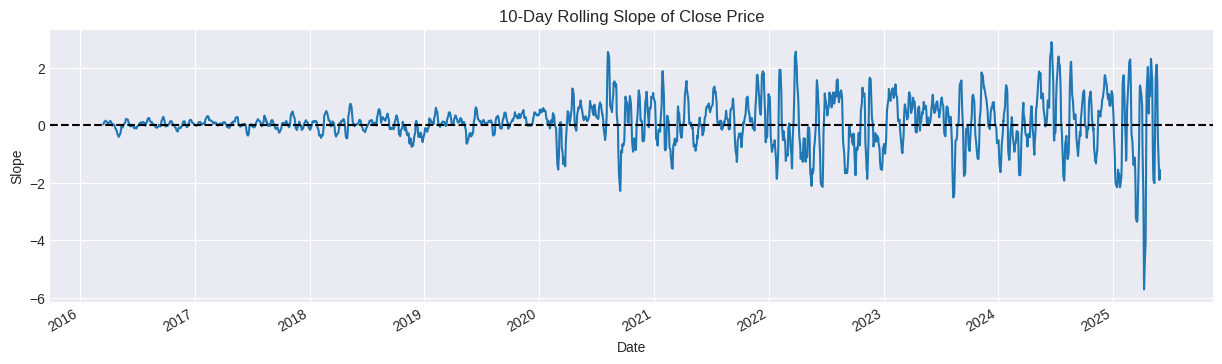

In [18]:
df['slope_10'].plot(figsize=(15, 4), title='10-Day Rolling Slope of Close Price')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Slope')
plt.show()


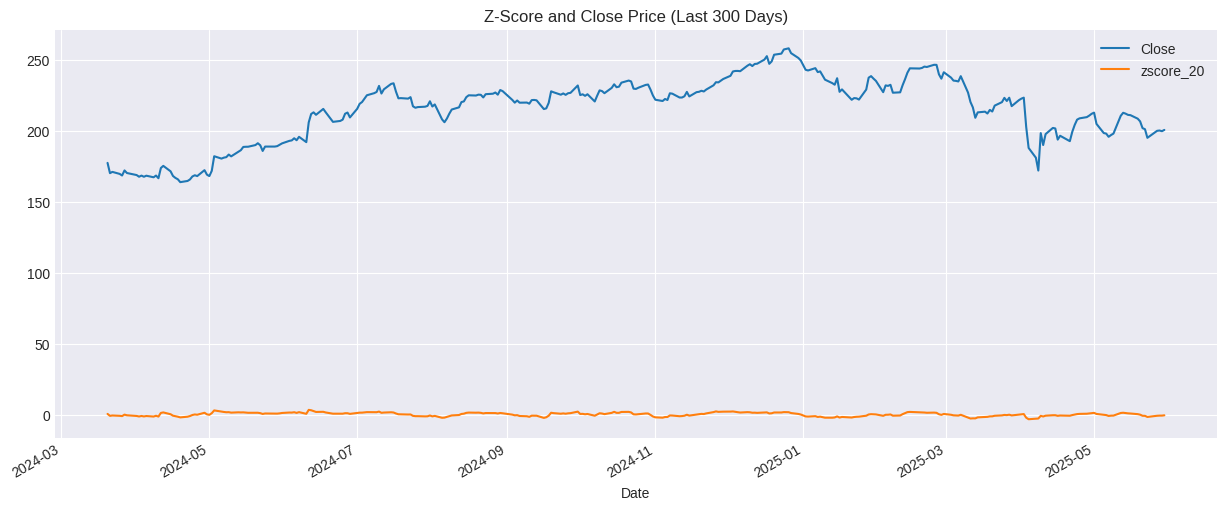

In [19]:
df[['Close', 'zscore_20']].tail(300).plot(figsize=(15, 6), title='Z-Score and Close Price (Last 300 Days)')
plt.show()


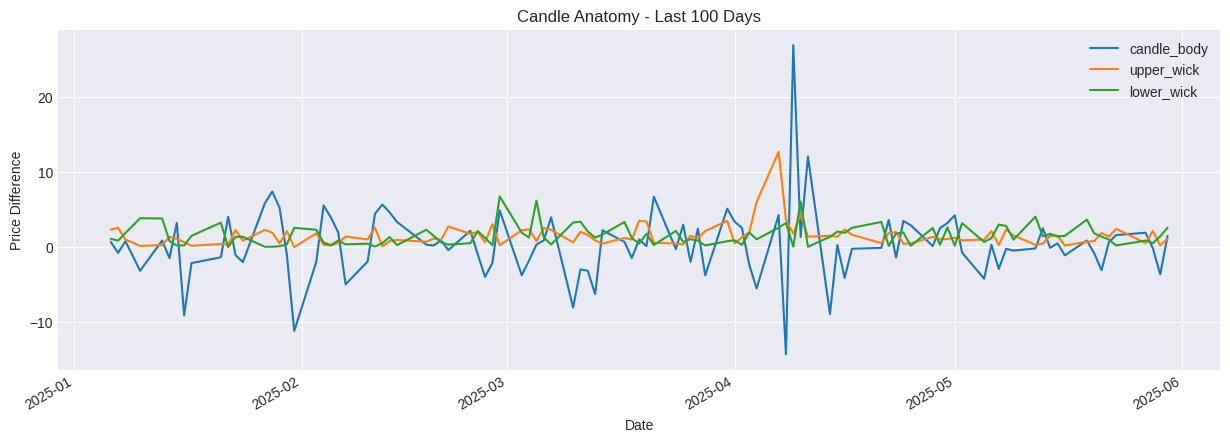

In [20]:
df[['candle_body', 'upper_wick', 'lower_wick']].tail(100).plot(figsize=(15, 5), title='Candle Anatomy - Last 100 Days')
plt.ylabel('Price Difference')
plt.show()


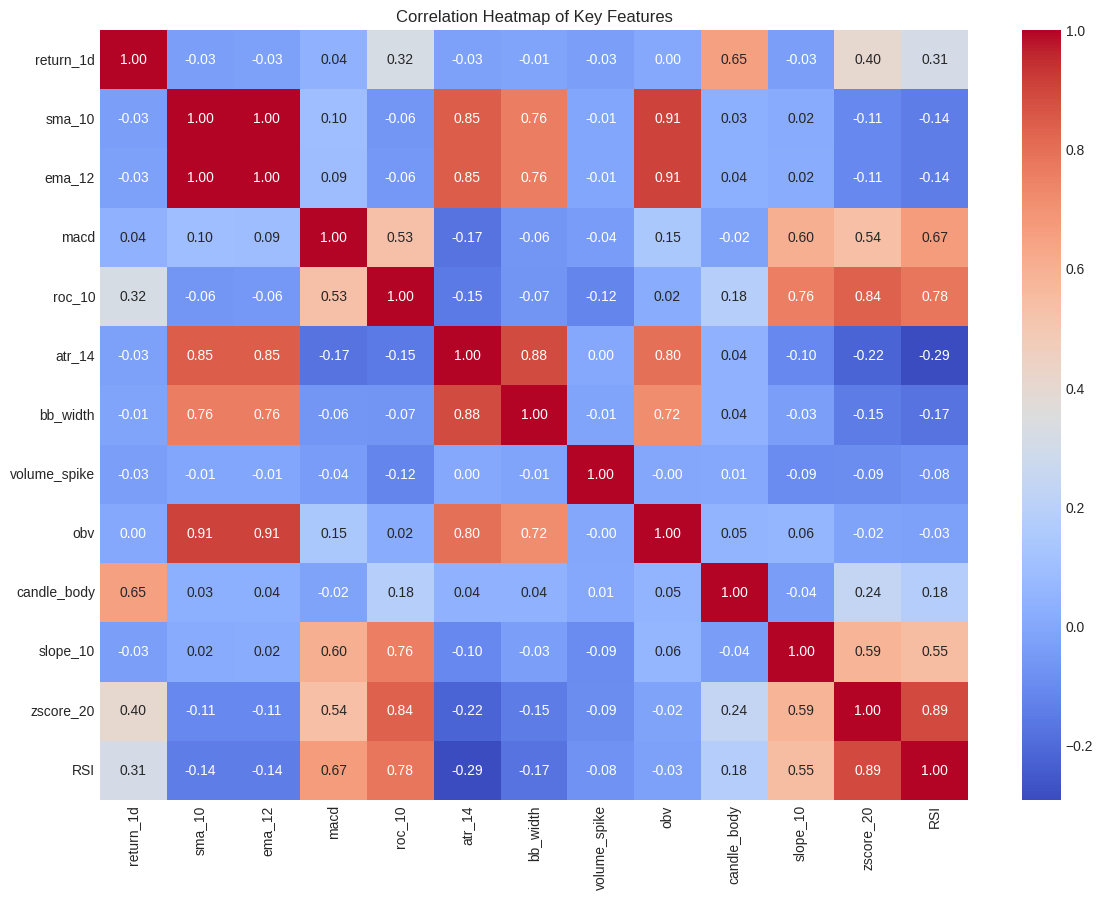

In [21]:
import seaborn as sns

features_to_plot = [
    'return_1d', 'sma_10', 'ema_12', 'macd', 'roc_10', 'atr_14',
    'bb_width', 'volume_spike', 'obv', 'candle_body', 'slope_10', 'zscore_20', 'RSI'
]

plt.figure(figsize=(14, 10))
sns.heatmap(df[features_to_plot].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Key Features")
plt.show()


In [24]:
doji_days = df[df['doji_flag']].shape[0]
total_days = df.shape[0]
print(f" Doji patterns found in {doji_days} out of {total_days} trading days (~{100 * doji_days / total_days:.2f}%)")


 Doji patterns found in 248 out of 2317 trading days (~10.70%)
